# 2017 ESPN Fantasy Football Draft Analysis

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Load data from Postgres DB

In [2]:
conn_str = "dbname = draft_analysis user = scraper"
conn = psycopg2.connect(conn_str)

In [3]:
query = "SELECT o.league_id || '_' || o.owner_id id, d.pick_number, p.position \
            FROM Draft2017.FantasyOwner o \
            NATURAL JOIN Draft2017.DraftPick d \
            NATURAL JOIN Draft2017.Player p \
            NATURAL JOIN Draft2017.FantasyLeague lg \
            WHERE lg.ppr_points = 0 \
            ORDER BY 1;"

In [4]:
data = pd.read_sql(query, conn)
data.head()

,id,pick_number,position
0,614546_1,2,wr
1,614546_1,10,rb
2,614546_1,18,rb
3,614546_1,34,wr
4,614546_1,66,wr


### Re-format and filter data

In [5]:
data = data.pivot(columns='pick_number', values='position',index='id')
data.head()

pick_number,1,2,3,4,5,6,7,8,9,10,...,411,412,413,414,415,416,417,418,419,420
id,,,,,,,,,,,,,,,,,,,,,
614546_1,NaN,wr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614546_2,NaN,NaN,NaN,NaN,NaN,NaN,wr,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614546_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614546_4,NaN,NaN,NaN,NaN,NaN,rb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614546_5,NaN,NaN,NaN,rb,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pick_dist = []
def num_picks(row):
    pick_dist.append(row.count())

data.apply(lambda row: num_picks(row),axis=1);

/Users/jsage/miniconda3/envs/DataAnalysis/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


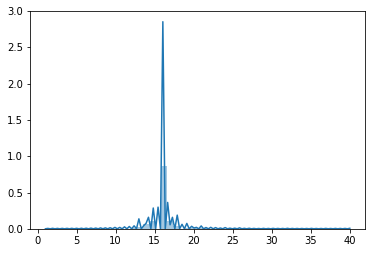

In [7]:
sns.distplot(pick_dist)

In [8]:
pd.Series(pick_dist).value_counts().head()

16    19687
15     2490
17     2319
14     1669
18      994
dtype: int64

Clearly the vast majority of leagues have 16 player rosters. For simplicity I will only consider these leagues in my analysis.

In [9]:
def picks_filter(row, minimum, maximum):
    if row.count() >= minimum and row.count() <= maximum:
        return True
    else:
        return False

In [10]:
minimum = 16
maximum = 16
data['include'] = data.apply(lambda row: picks_filter(row, minimum, maximum),axis=1)

In [11]:
data = data[data.include]
data = data.drop('include',axis=1)

In [12]:
col_names = ['round_'+ str(x) for x in range(1,maximum+1)]
def arrange_by_pick(row):
    picks = row.dropna()
    picks.index = col_names
    return picks

In [13]:
data = data.apply(lambda row: arrange_by_pick(row), axis=1)

### Retrieve league data to filter out defensive leagues
A minority of fantasy leagues in this dataset contain at least one Independent Defensive Player (IDP) on their roster. Because these leagues are not very common, I will exclude them from my analysis.

In [14]:
query_lg = "SELECT * FROM Draft2017.FantasyLeague lg WHERE lg.ppr_points = 0;"

In [15]:
lg_data = pd.read_sql(query_lg, conn, index_col='league_id')

In [16]:
lg_data.columns

Index(['league_name', 'year', 'draft_type', 'num_teams', 'scoring_type',
       'roster_size', 'num_starters', 'num_bench', 'ppr_points', 'keepers',
       'num_rostered_qb', 'num_rostered_rb', 'num_rostered_rb_wr',
       'num_rostered_wr', 'num_rostered_te', 'num_rostered_d_st',
       'num_rostered_k', 'num_rostered_be', 'num_rostered_rb_wr_te',
       'num_rostered_ir', 'num_rostered_wr_te', 'num_rostered_dt',
       'num_rostered_de', 'num_rostered_lb', 'num_rostered_edr',
       'num_rostered_cb', 'num_rostered_s', 'num_rostered_dp',
       'num_rostered_p', 'num_rostered_hc', 'num_rostered_op',
       'num_rostered_dl', 'num_rostered_db'],
      dtype='object')

In [17]:
def check_defensive(row):
    defensive_pos = ['dt', 'de', 'lb', 'edr', 'cb', 's', 'dp', 'p', 'hc', 'dl', 'db']
    for pos in defensive_pos:
        if row['num_rostered_' + pos] > 0:
            return True
    return False

In [18]:
lg_data['defensive_pos'] = lg_data.apply(lambda row: check_defensive(row),axis=1)

In [19]:
data = data[~data.apply(lambda row: lg_data.loc[int(row.name.split('_')[0])].defensive_pos, axis=1)]

### Add preformance data to draft data
To learn how different drafting strategies impact fantasy team preformance, we need a quantitative measure of each fantasy team's success. One choice for such a metric would be percentage of matchups won, but because winning percentage is also impacted by the strength of matchup opponents I will instead use total points scored. Because scoring formats vary from league to league, I will convert the points scored by each team to the number of standard deviations away from the mean number of points scored in their league. In essence, this number reflects a fantasy football team's preformance relative to the other teams in their league.

In [20]:
query_pts = "SELECT owner.league_id || '_' || owner.owner_id id, owner.pts_scored \
                FROM Draft2017.FantasyOwner owner NATURAL JOIN Draft2017.FantasyLeague lg \
                WHERE lg.ppr_points = 0;"

In [21]:
pts_data = pd.read_sql(query_pts, conn, index_col='id')

In [22]:
pts_data.head()

,pts_scored
id,
614546_2,1565
614546_7,1483
614546_1,1457
614546_3,1314
614546_4,1381


In [23]:
pts_data['league_id'] = pts_data.apply(lambda row: row.name.split('_')[0], axis=1)
pts_data['team_id'] = pts_data.apply(lambda row: row.name.split('_')[1], axis=1)
pts_data['relative_preformance'] = pts_data.groupby(['league_id']).pts_scored.apply(lambda p: (p - np.mean(p)) / np.std(p))

In [24]:
data['relative_preformance'] = pts_data['relative_preformance']

In [25]:
data.head()

,round_1,round_2,round_3,round_4,round_5,round_6,round_7,round_8,round_9,round_10,round_11,round_12,round_13,round_14,round_15,round_16,relative_preformance
id,,,,,,,,,,,,,,,,,
614588_1,rb,te,qb,wr,wr,rb,wr,wr,rb,rb,d_st,qb,te,rb,k,d_st,0.234706
614588_13,rb,qb,rb,wr,rb,wr,te,wr,rb,wr,wr,rb,wr,d_st,k,d_st,1.987314
614588_14,wr,rb,wr,rb,qb,wr,rb,wr,te,qb,wr,rb,d_st,k,rb,rb,-0.872204
614588_21,wr,rb,rb,qb,wr,rb,k,rb,rb,wr,d_st,te,qb,rb,wr,wr,1.341616
614588_22,wr,wr,wr,wr,rb,te,rb,rb,wr,rb,rb,qb,rb,k,wr,d_st,-0.626224


## Model Building

In [26]:
import statsmodels.api as sm
from patsy import dmatrices

### Build Design Matricies

In [27]:
feature_str = "C({0},Treatment(reference='rb'))"
design_str = 'relative_preformance ~ ' + ' + '.join([feature_str.format(x) for x in data.columns[:-1]])

In [28]:
y_lm, X_lm = dmatrices(data=data, formula_like=design_str)

### Linear Model

In [29]:
lm = sm.OLS(y_lm, X_lm)
lm_results = lm.fit()

In [30]:
results = pd.DataFrame({'param_name':lm.exog_names,'coeff':lm_results.params, 'pvalue':lm_results.pvalues})

In [31]:
results[(results.pvalue<=0.05) & (results.param_name!='Intercept')].sort_values('coeff')

,param_name,coeff,pvalue
10,"C(round_2, Treatment(reference='rb'))[T.wr]",-0.436606,3.946933e-133
15,"C(round_3, Treatment(reference='rb'))[T.wr]",-0.416766,1.146870e-118
1,"C(round_1, Treatment(reference='rb'))[T.d_st]",-0.379041,3.689296e-02
8,"C(round_2, Treatment(reference='rb'))[T.qb]",-0.366213,6.891177e-34
3,"C(round_1, Treatment(reference='rb'))[T.qb]",-0.356411,8.264735e-29
22,"C(round_5, Treatment(reference='rb'))[T.k]",-0.338602,9.998769e-04
13,"C(round_3, Treatment(reference='rb'))[T.qb]",-0.310005,3.009370e-27
6,"C(round_2, Treatment(reference='rb'))[T.d_st]",-0.286627,2.809024e-02
11,"C(round_3, Treatment(reference='rb'))[T.d_st]",-0.243564,1.925128e-02
27,"C(round_6, Treatment(reference='rb'))[T.k]",-0.239578,2.223956e-03


### Interpretation

The coeficients in this model can be interpreted as the impact on 'relative_preformance' of drafting the position in brackets compared to drafting a running back ('rb') in a given round. For example, the coefficient with name "C(round_2, Treatment(reference='rb'))[T.wr]" and value -0.437 means that the model predicts a team that drafts a wide reciever in the 2nd round will end the season with almost half (0.437) of a standard deviation fewer points scored than the same team who drafted a runnning back in the same round.

### Limitations

- Does not consider league context (ie. when other quartebacks were drafted in a league)
- Does not consider team context (ie. how many running backs a team has already drafted)
- Highly dependent on individual player preformances in the given year

### Improvements

- Add league size to model / only use 10 team leagues
- Include individual players in models
    - Would likely need significantly more data for this to avoid overfitting
- Scrape/include other years drafting data as well

### Conclusions
Ultimately the results of this model do not provide any earth-shattering findings about fantasy football draft strategy. The inherent variability of individual player performances during a given season is by far the most important factor in determining relative team performance. In order to infer meaningful insights into positional drafting strategies, the model would need to account for individual player preformances and/or be fitted on data from many seasons. However, this modeling excercise was a very useful jumping off point for more in-depth analysis.